# Libraries

In [6]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import torchvision
torch.manual_seed(0) # Set for testing purposes, please do not change!

# Google Colab / Your Device
**Because directory system in your device(laptop) is different from google drive, so first determine this section first**

In [7]:
# roots
# D:\GitHub\gan-lab\Dataset
# '/content/drive/MyDrive/gan-lab/Dataset'
root_ds='D:\GitHub\gan-lab\Dataset'

# D:\GitHub\gan-lab\Models
# "/content/drive/MyDrive/gan-lab/Models"
root_models = 'D:\GitHub\gan-lab\Models'

# devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**NOTE:**
Unlike Basic GANs that you played with Nodes, in DCGANs you will play with Channels

# Information

1. We have NO any pooling layer
2. We have 2D batchnorm layer in both G and D.
3. We have NO fully connected hidden layer (nn.Linear).
4. ReLU in hidden layers - Tanh in final layer (Generators)
5. LeakyReLU in hidden layers - NO activation in final layer (Discriminator)
6. You will build a generator using 4 layers (3 hidden layers + 1 output layer)
7. You will use 3 layers in your discriminator's neural network

# Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, C_noise, C_hidden, C_image):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.gen_block(C_noise   , C_hidden*4, K=3, S=2),
            self.gen_block(C_hidden*4, C_hidden*2, K=4, S=1),
            self.gen_block(C_hidden*2, C_hidden*1, K=3, S=2),
            self.gen_block(C_hidden*1  , C_image , K=4, S=2, final_layer=True)
        )

    def gen_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.gen(x)

# Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, C_image, C_hidden):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            self.dis_block(C_image   , C_hidden*1, K=4, S=2),
            self.dis_block(C_hidden*1, C_hidden*2, K=4, S=2),
            self.dis_block(C_hidden*2, 1         , K=4, S=2, final_layer=True),
        )

    def dis_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.LeakyReLU(inplace=True, negative_slope=0.2)
            )

    def forward(self, x):
        return self.dis(x).view(x.shape[0], -1)

# Noise

In [10]:
def get_noise(N_noise, C_noise, device='cpu'):
    return torch.randn(N_noise, C_noise, device=device).view(-1, C_noise, 1, 1)

# Losses (NEW)

# TEST #

In [180]:
# Sample numbers of noise and image
N_noise = 128
batch_size =128

# Channels of noise and image
C_noise = 64
C_image = 1

C_hidden_gen = 64
C_hidden_dis = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

for x, _ in dataloader:
    x=x
    break

z = get_noise(N_noise, C_noise)

In [181]:
print(x.shape)
print(z.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 64, 1, 1])


In [182]:
gen = Generator(C_noise, C_hidden_gen, C_image)
dis = Discriminator(C_image, C_hidden_dis)

#### START

**WARNING**
write `raiseerror` in your function when N_z and N_x is not same

In [183]:
def gradient_penlaty(dis, x_hat):
    # False require_grad of all discriminator parameters (weight and bias)
    dis.requires_grad_(False)
    # Convert x_hat to Parameter (True require_grad)
    x_hat_p = nn.parameter.Parameter(x_hat)
    # Feed x_hat_p to Discriminator
    score = dis(x_hat_p)
    # Gradient
    score.backward()
    # Reset Status
    dis.requires_grad_(True)
    return (torch.linalg.norm ( torch.flatten(x_hat_p.grad, start_dim=1), 2 ) - 1 )**2

def get_loss_dis (x, z, gen, dis, lamda):
    x=x[0:1]
    z=z[0:1]

    # create x_hat
    x_hat = gen(z).detach()

    # interpolation
    epsilon = torch.empty(1).uniform_(0,1)
    x_hat = (epsilon * x + (1-epsilon) * x_hat)

    return dis(x_hat) - dis(x) + lamda * gradient_penlaty(dis, x_hat)

In [184]:
get_loss_dis(x, z, gen, dis, 10)

tensor([[0.0921]], grad_fn=<AddBackward0>)

In [185]:
def get_loss_gen (gen, dis, N_noise, C_noise, device):
    z = get_noise(N_noise, C_noise, device)
    return torch.mean(-dis(gen(z)), dim=0)

In [186]:
get_loss_gen (gen, dis, N_noise, C_noise, 'cpu')

tensor([0.0989], grad_fn=<MeanBackward1>)

#### END

# END TEST

In [ ]:
def get_loss_dis(gen, dis,
                 real_image,
                 N_noise, C_noise,
                 device):

    x = real_image
    x_hat = gen( get_noise(N_noise, C_noise, device=device) ).detach()

    return torch.mean(dis(x_hat), dim=0)   -   torch.mean(dis(x), dim=0 )

In [ ]:
def get_loss_gen(gen, dis,
                 N_noise, C_noise,
                 device):

    x_hat = gen( get_noise(N_noise, C_noise, device=device) )

    return torch.mean(-dis(x_hat), dim=0 )

# Helper Functions

In [11]:
def save_model(gen, dis, epoch, root, mode = None):
    # directory system in colab and pc is different.
    if mode == 'colab':
        filename = root + f'/model_epoch_{epoch}.pt'
    else:
        filename = root + f'\model_epoch_{epoch}.pt'

    torch.save({'epoch' : epoch,
              'model_dis_state_dict' : dis.state_dict(),
              'model_gen_state_dict' : gen.state_dict()},
              filename)

In [12]:
# when you want to continue training GAN from last epoch.
def load_model(gen, dis, root):
    # root = last generator and discriminator parameters that has been saved.
    # gen  = un-initialized generator
    # dis  = un-initialized discriminator

    models=torch.load(root)
    gen.load_state_dict(models['model_gen_state_dict'])
    dis.load_state_dict(models['model_dis_state_dict'])
    return models['epoch']

In [13]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [14]:
def weights_init(submodules):
    if isinstance(submodules, nn.Conv2d) or isinstance(submodules, nn.ConvTranspose2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
    if isinstance(submodules, nn.BatchNorm2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        torch.nn.init.constant_(submodules.bias, 0)

# Hyperparameters

**WARNING**
batch_size and N_noise in some iteration it is not same!

In [15]:
# Sample numbers of noise and image
N_noise = 128
batch_size =128

# Channels of noise and image
C_noise = 64
C_image = 1

# Channels of hidden layers
C_hidden_gen = 64
C_hidden_dis = 16

# lr/epoch/disp
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 50
disp_freq=100

# Real Image

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

# Create Models / Criterion / Optimizers

In [17]:
# get instance from models
gen = Generator(C_noise, C_hidden_gen, C_image).to(device)
dis = Discriminator(C_image, C_hidden_dis).to(device)

# Initialize
gen = gen.apply(weights_init)
dis = dis.apply(weights_init)

# Optimizers
optim_dis = torch.optim.Adam(dis.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

In [16]:
for x,_ in dataloader:
    x=x
    break
x=x.to(device)

In [18]:
get_loss_dis(gen,dis, x,N_noise, C_noise, device)

tensor([6.9752e-05], device='cuda:0', grad_fn=<SubBackward0>)

# Train

############################################################
###### Epoch 1 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: -0.77	Loss Gen: -1.77


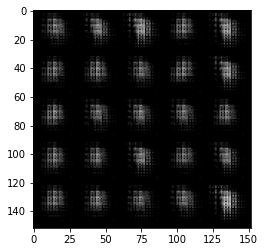

############################################################
###### Epoch 2 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: -8.85	Loss Gen: 2.31


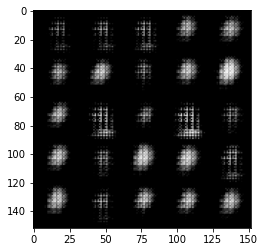

############################################################
###### Epoch 3 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: -5.24	Loss Gen: -15.28


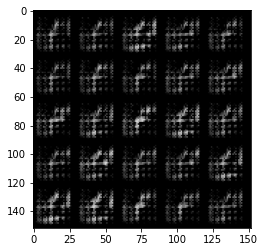

  0%|          | 0/469 [00:00<?, ?it/s]

############################################################
###### Epoch 4 #############################################
############################################################


KeyboardInterrupt: 

In [19]:
loss_gen_min = np.Inf

for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    dis.train()

    for real_image, _ in tqdm(dataloader):
        # GPU (model and data)
        real_image=real_image.to(device)

        # Discriminator Learning
        optim_dis.zero_grad()
        loss_dis = get_loss_dis(gen, dis, real_image, N_noise, C_noise, device)
        loss_dis.backward()
        optim_dis.step()

        # Generator Learning
        optim_gen.zero_grad()
        loss_gen = get_loss_gen(gen, dis, N_noise, C_noise, device)
        loss_gen.backward()
        optim_gen.step()

    # Save parameters of discriminator and generator
    save_model(gen, dis, epoch, root_models, mode='colab')
    print("Loss Dis: {:.2f}\tLoss Gen: {:.2f}".format(loss_dis.item(),loss_gen.item()))

    gen.eval()
    fake_images = gen(get_noise(25, C_noise, device=device))
    show_tensor_images(fake_images)